# Project mobile game





#### Write a function to calculate the retention rate.
#### Analyze the results from an A/B test in which two groups of users were offered different sets of promotional offers.
#### Propose metrics for evaluating the results of the latest themed event in the game.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pingouin as pg
from scipy. stats import ttest_ind
from scipy.stats import bootstrap
import scipy.stats as ss
import statsmodels.api as sm


/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs




# Retention

#### Retention is one of the most crucial metrics for the company.  Write a function that calculates player retention (daily from the player's registration date).


Retention is a metric that indicates how users return to the product (often indicating whether they like it).

Unloading, checking, and preparing data.

In [2]:
reg_data=pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-y-baraulia/shared/problem1-reg_data.csv', sep = ';')

In [3]:
auth_data=pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-y-baraulia/shared/problem1-auth_data.csv', sep = ';')

Registration time data.


In [4]:
reg_data.head()


,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


DataFrame size.

In [5]:
reg_data.shape

(1000000, 2)

Checking for duplicate entries.

In [6]:
reg_data.duplicated().sum()

0

Data type.


In [7]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

Checking for missing data.



In [8]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64


Converting the date from UNIX format to the year-month-day format.


In [9]:
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit = 's').dt.strftime('%Y-%m-%d')
reg_data['reg_ts']=pd.to_datetime(reg_data['reg_ts'])

In [10]:
reg_data.dtypes

reg_ts    datetime64[ns]
uid                int64
dtype: object

In [11]:
reg_data.head()

,reg_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,2000-01-13,3
3,2000-05-28,4
4,2000-09-16,5


The minimum and maximum registration dates for users.


In [12]:
reg_data['reg_ts'].min()

Timestamp('1998-11-18 00:00:00')

In [13]:
reg_data['reg_ts'].max()

Timestamp('2020-09-23 00:00:00')

The DataFrame contains data spanning over 20 years.


Data on the time of users' entry into the game.


In [14]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


DataFrame size.


In [15]:
auth_data.shape

(9601013, 2)

Checking for duplicate entries.

In [16]:
auth_data.duplicated().sum()

0

Data type.


In [17]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

Checking for missing data.






In [18]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

Converting the date from UNIX format to the year-month-day format.

In [19]:
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit = 's').dt.strftime('%Y-%m-%d')
auth_data['auth_ts']=pd.to_datetime(auth_data['auth_ts'])
auth_data.dtypes

auth_ts    datetime64[ns]
uid                 int64
dtype: object

In [20]:
auth_data.head()

,auth_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,1999-07-25,2
3,1999-07-31,2
4,1999-08-05,2


The minimum and maximum registration dates for users.


In [21]:
auth_data['auth_ts'].min()

Timestamp('1998-11-18 00:00:00')

In [22]:
auth_data['auth_ts'].max()

Timestamp('2020-09-23 00:00:00')

The DataFrame contains data spanning over 20 years.

For further processing, we merge the DataFrames. 

In [23]:
df=reg_data.merge(auth_data, how='inner', on='uid')
df.head()


,reg_ts,uid,auth_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-22,2,1999-07-25
3,1999-07-22,2,1999-07-31
4,1999-07-22,2,1999-08-05


Creating a column with the number of days from registration to the first game entry.

In [24]:
df['dif_ts']=(df.auth_ts - df.reg_ts).dt.days
df.head()

,reg_ts,uid,auth_ts,dif_ts
0,1998-11-18,1,1998-11-18,0
1,1999-07-22,2,1999-07-22,0
2,1999-07-22,2,1999-07-25,3
3,1999-07-22,2,1999-07-31,9
4,1999-07-22,2,1999-08-05,14


Let's look at the maximum number of days from registration to the first entry and the number of users with such durations. Displaying the top 10.

In [25]:
df.groupby('dif_ts').agg({'uid': 'nunique'}).sort_values('dif_ts', ascending=False).head(10)

,uid
dif_ts,
7729,1
7727,1
7721,1
7720,1
7716,1
7712,1
7709,1
7706,1
7704,1


Since the DataFrame contains data spanning over 20 years, we can examine the periods of maximum/minimum activity in terms of registration and entry.

Let's look at the number of unique users registering in the app by dates. We'll sort in descending/ascending order and display the top 30.

In [26]:
df.groupby('reg_ts').agg({'uid':'nunique'}).sort_values('uid', ascending=False).head(30)

,uid
reg_ts,
2020-09-22,1641
2020-09-21,1638
2020-09-20,1636
2020-09-19,1634
2020-09-18,1630
2020-09-17,1628
2020-09-16,1625
2020-09-15,1623
2020-09-14,1619


In [27]:
df.groupby('reg_ts').agg({'uid':'nunique'}).sort_values('uid').head(30)

,uid
reg_ts,
1998-11-18,1
2008-04-01,1
2008-04-02,1
2008-04-03,1
2008-04-05,1
2008-04-06,1
2008-04-07,1
2008-04-08,1
2008-04-09,1



Let's look at the number of unique users who entered the app by dates. We'll sort in descending/ascending order and display the top 30.

In [28]:
df.groupby('auth_ts').agg({'uid':'nunique'}).sort_values('uid', ascending=False).head(30)

,uid
auth_ts,
2020-09-21,15948
2020-09-20,15829
2020-09-14,15790
2020-09-17,15783
2020-09-22,15755
2020-09-19,15731
2020-09-18,15704
2020-09-16,15641
2020-09-13,15603


In [29]:
df.groupby('auth_ts').agg({'uid':'nunique'}).sort_values('uid').head(30)

,uid
auth_ts,
1998-11-18,1
2004-10-13,1
2004-10-14,1
2004-10-16,1
2004-10-17,1
2004-10-19,1
2004-10-20,1
2004-10-23,1
2004-10-25,1


Creating cohorts by counting the number of unique users based on the registration date and the number of days from registration to the first game entry.

In [30]:
cohort = df.groupby(['reg_ts', 'dif_ts'], as_index = False).agg({'uid' : 'nunique'}).rename(columns={'uid' : 'users'})

In [31]:
cohort.head()

,reg_ts,dif_ts,users
0,1998-11-18,0,1
1,1999-07-22,0,1
2,1999-07-22,3,1
3,1999-07-22,9,1
4,1999-07-22,14,1


Creating a table and calculating retention.

In [32]:
retention=cohort.pivot_table(index='reg_ts', columns='dif_ts', values='users').rename_axis('registration_date')
cohort_size = retention.iloc[:, 0]
retention_rate = retention.divide(cohort_size, axis=0)
retention_rate.head(50)

dif_ts,0,1,2,3,4,5,6,7,8,9,...,7701,7704,7706,7709,7712,7716,7720,7721,7727,7729
registration_date,,,,,,,,,,,,,,,,,,,,,
1998-11-18,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-07-22,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2000-01-13,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-28,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-09-16,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-19,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-03-10,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-05-21,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-07-24,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Compiling a function that calculates player retention (daily from the player's registration date).


In [33]:
def retention(reg_data, auth_data, date_nach, date_kon):
    
    #Выбираем только необходимый период, за который будет подсчитаваться retention
    reg_data = reg_data.query('reg_ts >= @date_nach and reg_ts <= @date_kon')
    
    #Объединяем датафреймы
    df = reg_data.merge(auth_data, how = 'inner', on = 'uid')
   
    #Создаем колонку с количеством дней с момента регистрации и до момента первого входа в игру
    df['dif_ts']=(df.auth_ts - df.reg_ts).dt.days
    
    #Создаем когорты, подсчитывая колчисетво уникальных пользователей по дате регистрации и количеству дней, с момента регистрации и до первого входа в игру 
    cohort = df.groupby(['reg_ts', 'dif_ts'], as_index = False).\
                            agg({'uid' : 'count'}).\
                            rename(columns={'uid' : 'users'})
    #Создаем таблицу
    retention = cohort.pivot_table(index = 'reg_ts', columns = 'dif_ts', values='users').\
                            rename_axis('registration_date')
    #Размеры когорт
    cohort_size = retention.iloc[:, 0]
    
    #Считаем Retention
    retention_rate = retention.divide(cohort_size, axis=0)
    
    
    
    #Визуализируем
    plt.figure(figsize=(24, 16))
    sns.heatmap( retention_rate.iloc[1:31, 1:31] , linewidth=.1, cmap="coolwarm", annot=True, fmt='.1%', vmin=0, vmax=0.08)

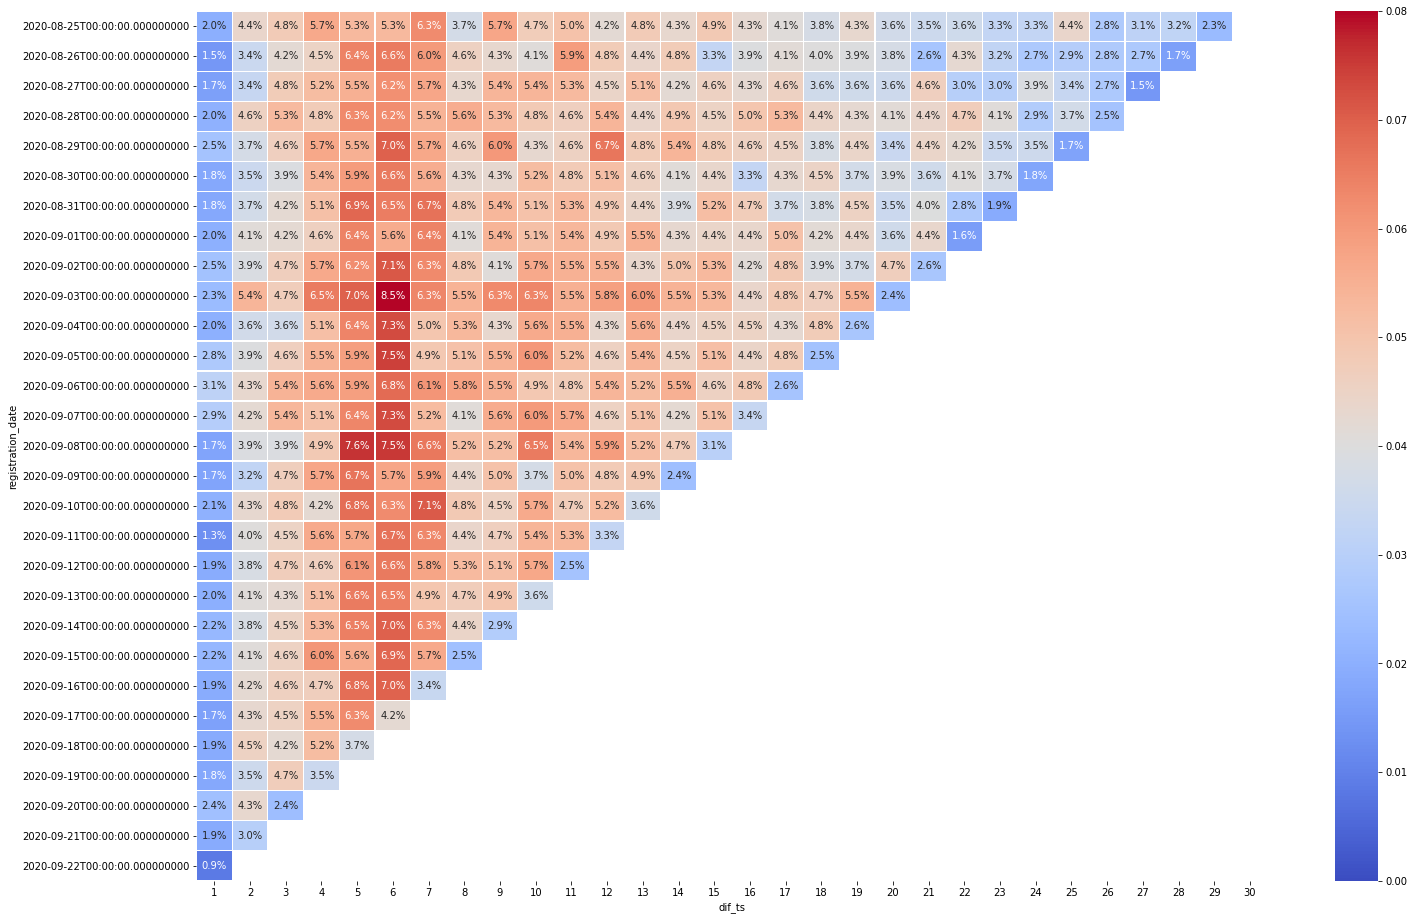

In [34]:
retention(reg_data, auth_data, date_nach = '2020-08-24', date_kon = '2020-09-22')

## Analyze the results from an A/B test in which two groups of users were offered different sets of promotional offers.

#### There are results from an A/B test in which two groups of users were offered different sets of promotional offers. It is known that the ARPU in the test group is 5% higher than in the control group. Meanwhile, in the control group, 1928 players out of 202103 turned out to be paying, and in the test group – 1805 out of 202667.

#### Which set of offers can be considered the best? What metrics should be analyzed to make the right decision and how?

Unloading, checking, and preparing data.


In [35]:
rezab=pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-y-baraulia/Проект_1_Задание_2.csv', sep=';')

In [36]:
rezab.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


DataFrame size.

In [37]:
rezab.shape

(404770, 3)

Data type.

In [38]:
rezab.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object


Checking for missing data.

In [39]:
rezab.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

Checking for duplicate entries.

In [40]:
rezab.duplicated().sum()

0

Since we have two groups, A (control group) and B (test group), let's split the DataFrame into two.


DataFrame with the control group.

In [41]:
group_kontr=rezab.query('testgroup=="a"')
group_kontr.head()

,user_id,revenue,testgroup
1,2,0,a
2,3,0,a
9,10,0,a
10,11,0,a
11,12,0,a



Data type.


In [42]:
group_kontr.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

DataFrame size.




In [43]:
group_kontr.shape

(202103, 3)

Checking for missing data.

In [44]:
group_kontr.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

Checking for duplicate entries. 

In [45]:
group_kontr.duplicated().sum()

0

Descriptive statistics.

In [46]:
group_kontr.describe()

,user_id,revenue
count,202103.000000,202103.000000
mean,202555.909843,25.413720
std,116802.329266,920.768137
min,2.000000,0.000000
25%,101502.500000,0.000000
50%,202988.000000,0.000000
75%,303559.000000,0.000000
max,404769.000000,37433.000000


Number of paying users.

In [47]:
group_kontr.query('revenue>0').user_id.count()

1928

DataFrame with the test group.

In [48]:
group_test=rezab.query('testgroup=="b"')
group_test.head()

,user_id,revenue,testgroup
0,1,0,b
3,4,0,b
4,5,0,b
5,6,0,b
6,7,0,b



Data type.

In [49]:
group_test.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

DataFrame size.

In [50]:
group_test.shape

(202667, 3)


Checking for missing data.

In [51]:
group_test.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

DataFrame size.

In [52]:
group_test.duplicated().sum()

0

Descriptive statistics.

In [53]:
group_test.describe()

,user_id,revenue
count,202667.000000,202667.000000
mean,202215.564389,26.751287
std,116891.926690,287.324162
min,1.000000,0.000000
25%,100855.500000,0.000000
50%,201821.000000,0.000000
75%,303602.500000,0.000000
max,404770.000000,4000.000000



Number of paying users.

In [54]:
group_test.query('revenue>0').user_id.count()

1805


To make the right decision on which set of offers is the best, it's worth analyzing ARPU, ARPPU, and CR (Conversion Rate).

ARPU - Average Revenue Per User. This metric is used to assess the average revenue brought in by each user.

ARPPU - Average Revenue Per Paying User. This metric is used to evaluate the average revenue brought in by each paying user.

CR (Conversion Rate) - Conversion to Paying Users.

Calculating ARPU.

In [55]:
ARPU_kontr= group_kontr.revenue.sum() / group_kontr.user_id.count()
ARPU_kontr

25.413719736965806

In [56]:
ARPU_test= group_test.revenue.sum() / group_test.user_id.count()
ARPU_test

26.75128659327863

Calculating ARPPU.

In [57]:
ARPPU_kontr= group_kontr.revenue.sum()/ group_kontr.query('revenue>0').user_id.count()
ARPPU_kontr

2663.9984439834025

In [58]:
ARPPU_test= group_test.revenue.sum()/ group_test.query('revenue>0').user_id.count()
ARPPU_test

3003.6581717451522

Calculating Conversion rate.

In [59]:
Conversion_rate_kontr = (group_kontr.query('revenue>0').user_id.count() / group_kontr.user_id.count())*100
Conversion_rate_kontr

0.9539690157988748

In [60]:
Conversion_rate_test = (group_test.query('revenue>0').user_id.count() / group_test.user_id.count())*100
Conversion_rate_test

0.8906235351586593

Based on the obtained data, it may seem that the offers in the test group are better than in the control group, as ARPU and ARPPU are higher, although the conversion to paying users is lower.

Let's formulate hypotheses:

H0 - Offers are good in both groups.
H1 - Offers are better in the test group.


Taking a look at the revenue in the groups.

In [61]:
rezab.groupby('testgroup').agg({'revenue': 'sum'})

,revenue
testgroup,
a,5136189
b,5421603


Let's examine the distribution of data in the groups.

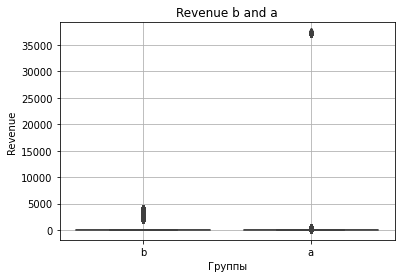

In [62]:
sns.boxplot(data=rezab,y="revenue", x="testgroup")
plt.xlabel('Группы')
plt.ylabel('Revenue')
plt.title('Revenue b and a')
plt.grid(True)

Seeing on the graph that in the control group, there are users with revenue exceeding 35000. It's essential to check whether these are outliers or if the data is distributed in such a way.

In [63]:
group_kontr.query('revenue>35000')

,user_id,revenue,testgroup
416,417,37324,a
4428,4429,37304,a
5777,5778,37315,a
8065,8066,37307,a
8743,8744,37334,a
...,...,...,...
360696,360697,37347,a
378668,378669,37297,a
389341,389342,37298,a
394580,394581,37302,a


In [64]:
group_kontr.query('revenue>35000').revenue.sum()

4590252

In [65]:
(group_kontr.query('revenue>35000').revenue.sum() / group_kontr.revenue.sum()) * 100


89.37077665950378

Seeing on the graph that in the control group, there are users with revenue exceeding 35000. It's essential to check whether these are outliers or if the data is distributed in such a way.


Let's test the data for normality:

H0 - Data is normally distributed
H1 - Data is not normally distributed

In [66]:
stats.normaltest(group_kontr.revenue)

NormaltestResult(statistic=585152.7312728433, pvalue=0.0)

In [67]:
stats.normaltest(group_test.revenue)

NormaltestResult(statistic=326622.39540856465, pvalue=0.0)


With a p-value = 0.0, we have grounds to reject H0, indicating that the data is not normally distributed.

Checking the data for homogeneity of variance:

H0 - Homogeneity is present
H1 - There is no homogeneity

In [68]:
ss.levene(group_kontr.revenue, group_test.revenue)

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

Variance is homogeneous.

Let's conduct an analysis of variance since we are comparing the mean (ARPU) of two groups.

H0 - There are no statistically significant differences; a 5% difference is not significant.
H1 - Differences are statistically significant.

In [69]:
 stats.f_oneway(group_kontr.revenue, group_test.revenue) 

F_onewayResult(statistic=0.38962894747014043, pvalue=0.5324948591043842)

With a p-value = 0.53, it indicates that we do not reject the null hypothesis.

Let's investigate ARPPU:

H0 - There are no statistically significant differences; ARPPU is not different.
H1 - Differences are statistically significant.


In [70]:
stats.ttest_ind(group_kontr.query('revenue>0').revenue,  group_test.query('revenue>0').revenue)

Ttest_indResult(statistic=-1.5917100176862002, pvalue=0.11153459157259504)


With the result indicating no statistically significant differences, we do not reject H0.

Additionally, we will conduct bootstrap.

ARPPU

In [71]:
bootstrap((group_kontr.query('revenue>0').revenue,), np.mean) 

BootstrapResult(confidence_interval=ConfidenceInterval(low=2281.0503404358087, high=3087.15305856129), standard_error=206.19523452690203)

In [72]:
bootstrap((group_test.query('revenue>0').revenue,), np.mean) 

BootstrapResult(confidence_interval=ConfidenceInterval(low=2976.905518813255, high=3029.2660030688166), standard_error=13.330984657273028)

Since the confidence intervals overlap, it may indicate the absence of statistically significant differences.

The bootstrap results also showed that there is no basis to reject the null hypothesis. Based on this, one can conclude that the offers in both groups are equally good.


We still need to check the Conversion Rate. We will conduct the test using the chi-square, as we are comparing categorical data, True for paying and False for non-paying.


In [73]:
pd.crosstab(rezab['testgroup'], rezab['revenue']!=0)

revenue,False,True
testgroup,,
a,200175,1928
b,200862,1805


In [74]:
stats.chi2_contingency(pd.crosstab(rezab['testgroup'], rezab['revenue']!=0))[:2]


(4.374729521260405, 0.03647561892312613)

The results indicate that the differences in conversion among paying users in the control group and the test group are statistically significant. It can be assumed that the offers in the control group perform better, meaning a greater number of users are willing to pay.

Conclusion:

To make the right decision, we analyzed ARPU, ARPPU, and CR using analysis of variance, t-test, bootstrap, and chi2_contingency.

The results do not provide a clear answer as to which group's set of offers is better. The 5% difference in ARPU is obtained by chance, and ARPPU does not differ significantly. However, statistically significant differences were found in the conversion to a paying user between the groups. This indicates that in the control group, there is a higher conversion (more paying users), but they pay less. In the test group, on the contrary, the conversion is lower, but paying users contribute more.

Based on this, we cannot give a definite answer about which group's offers are better. It will depend on whether we want to retain users willing to pay more or provide offers suitable for everyone.

## Propose metrics for evaluating the results of the latest themed event in the game.

#### In the game Plants & Gardens, thematic events are held every month, time-limited. In these events, players can obtain unique items for their garden and characters, additional coins, or bonuses. To receive the reward, players need to complete a series of levels within a specified time. What metrics can be used to evaluate the results of the last completed event?



#### Let's assume in another event, we complicate the event mechanics such that with each unsuccessful attempt to complete a level, the player will roll back several levels. Will the set of metrics for evaluating the result change? If yes, how?

Before moving on to the metrics, it's necessary to characterize the product.

The game belongs to the casual farm sim genre. The primary audience consists of women and men aged 30+, with stable income and an interest in gardening, country houses, or farming. Based on this, it can be assumed that players access the game approximately twice a day, during commuting to and from work, as well as on weekends when they have a free moment. User activity also increases in the fall-winter period when nostalgia for gardening and country houses reaches its peak.

Let's assume that the thematic event lasts for a week each month.

Metrics to evaluate the results of the last completed event:

##### DAU (Daily Active Users)
The number of unique users who accessed the product during the thematic event within a day.

##### WAU (Weekly Active Users)
The number of unique users who accessed the product during the thematic event within a week

##### MAU (Monthly Active Users)
The number of unique users who accessed the product during the thematic event within a month.

##### Conversion
The percentage of users participating in the thematic event relative to the total number of active users.

##### Retention
Shows the percentage of users who remained with the product after completing the event.

##### Churn
The number of users who left the application during the thematic event.

##### Average Session Time
Evaluates the average session time of a user engaged in the thematic event, i.e., how long they stayed in the product.

The obtained metrics of the past event can be compared with the metrics of a typical day. They should indicate how successful/unsuccessful it was. Based on experience, thematic events increase DAU, MAU, WAU, conversion, retention, and reduce churn since users have a new goal and method to get bonuses and coins without spending money.

You can also assess:

##### User Satisfaction

Usually assessed through star-rating surveys from 1 (poor) to 5 (excellent). The metric will show the average level of satisfaction of participants in the thematic event.

##### Average Number of Levels Completed by Event Participants

This metric will help evaluate the level of user engagement in the thematic event at the time of participation, i.e., at which level interest is lost.

##### Event Completion Rate

The percentage of participants from the total number of participating users who completed the event.

If in another event we complicate the event mechanics such that with each unsuccessful attempt to complete a level, the player will roll back several levels, the set of metrics WILL NOT CHANGE. Because we would still need to understand user behavior and make conclusions based on that, whether the event was successful or not.

